In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

In [2]:
Datadirectory = 'G:\FaceMaskDetection\Dataset'
Classes = ['Face_Mask', 'No_Mask']
img_size = 224

In [13]:
# reading the images and converting all to array

training_data = []

def create_training_data():
    
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_output = Classes.index(category) ## converting them to 0, 1 (labels)
        for img in os.listdir(path):
          
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size)) # converting image size to 224 * 224
                training_data.append([new_array, class_output])
            
            except Exception as e:
                pass

In [14]:
create_training_data()

In [17]:
len(training_data)


2169

In [18]:
# shuffle data

random.shuffle(training_data)

In [19]:
X = [] # data
y = [] # label (0, 1) , 0 ==> FaceMask, 1 ==> No_Mask

for features, label in training_data:
#     print('features is :', features)
#     print('label is:', label)
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)

0


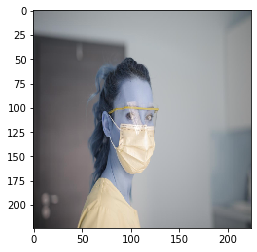

In [28]:
plt.imshow(X[1059])
print(y[1059])

In [29]:
# normalize data
X = X/255.0


In [30]:
# save prepared data
# save X:
pickle_out = open("G:\FaceMaskDetection\X.pickle", "wb")
pickle.dump(X, pickle_out, protocol=4)
pickle_out.close()

# save Y:
pickle_out = open("G:\FaceMaskDetection\y.pickle", "wb")
pickle.dump(y, pickle_out, protocol=4)
pickle_out.close()



In [74]:
# # load data
# # load X
pickle_in = open("G:\FaceMaskDetection\X.pickle", "rb")
X = pickle.load(pickle_in)

# load y
pickle_in = open("G:\FaceMaskDetection\y.pickle", "rb")
y = pickle.load(pickle_in)

In [75]:
print(len(X))
print(len(y))


2169
2169


In [76]:
# download deep learning model for training - Transfer learning
model = tf.keras.applications.mobilenet.MobileNet()

In [77]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [78]:
# set binary classification
base_input = model.layers[0].input
base_output = model.layers[-4].output

In [79]:
print(base_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 1024), dtype=tf.float32, name=None), name='dropout/Identity:0', description="created by layer 'dropout'")


In [80]:
flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(flat_layer)
final_output = layers.Activation('sigmoid')(final_output) 

In [81]:
final_output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'activation_2')>

In [82]:
new_model = keras.Model(inputs=base_input, outputs=final_output)

In [83]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [84]:
#from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='loss', mode='min', patience=3)
new_model.compile(loss='binary_crossentropy', optimizer = 'adam' ,metrics=['accuracy'])


In [85]:
new_model.fit(X, y, epochs=10, validation_split=0.1)

Epoch 1/10
61/61 [==============================] - 294s 5s/step - loss: 0.0861 - accuracy: 0.9566 - val_loss: 1.2099 - val_accuracy: 0.9032
Epoch 2/10
61/61 [==============================] - 321s 5s/step - loss: 0.0194 - accuracy: 0.9949 - val_loss: 5.6025 - val_accuracy: 0.5760
Epoch 3/10
61/61 [==============================] - 335s 5s/step - loss: 0.0268 - accuracy: 0.9955 - val_loss: 0.0700 - val_accuracy: 0.9908
Epoch 4/10
61/61 [==============================] - 335s 5s/step - loss: 7.2188e-04 - accuracy: 1.0000 - val_loss: 0.0099 - val_accuracy: 0.9954
Epoch 5/10
61/61 [==============================] - 352s 6s/step - loss: 1.2321e-05 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 6/10
61/61 [==============================] - 347s 6s/step - loss: 2.5577e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/10
61/61 [==============================] - 482s 8s/step - loss: 1.5405e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.00

In [3]:
# load and save the model:
#new_model = new_model.save('model')

# load
new_model = keras.models.load_model('model')

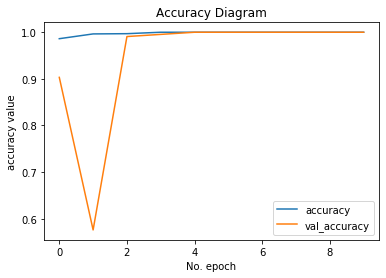

In [89]:
# plot history
plt.plot(new_model.history.history['accuracy'], label='accuracy')
plt.plot(new_model.history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Diagram')
plt.ylabel('accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

In [4]:
# check one image for predictions
import cv2

#frame = cv2.imread('05011_Mask.jpg')
#frame = cv2.imread('test2_FaceMask.jpg')

frame = cv2.imread('test_NoMask.jpg')
# aval ro on axe test bgir mikham ro halate khodesh bbinam baad berim vase baadi

final_image = cv2.resize(frame, (img_size, img_size))
# ss = final_image[70:,:, :]
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image / 255.0
print(final_image.shape)

(1, 224, 224, 3)


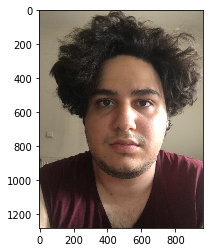

In [5]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# mese hamin anjam midam eshtebah mikone
# mishe ye test konim manm bbinam result haro are shayad hamin 255 bod asan :)
# bbin size ha b nazar yeki nistan - khob khate 8 be bad mage hamaro nemiad yeki mikone?
# bezar check kOnim
# man final result ro didam :) sorry 
# ye sample k b to shabih tar bashe nadari ? manzoret chie? beram to dataset esh bebinim?


In [6]:
prediction = new_model.predict(final_image)
print(prediction)

[[1.]]


(1, 224, 224, 3)
predictions is:  [[0.07753733]]
(1, 224, 224, 3)
predictions is:  [[0.02691689]]
(1, 224, 224, 3)
predictions is:  [[0.43155548]]
(1, 224, 224, 3)
predictions is:  [[0.3052521]]
(1, 224, 224, 3)
predictions is:  [[0.02658063]]
(1, 224, 224, 3)
predictions is:  [[0.16982073]]
(1, 224, 224, 3)
predictions is:  [[0.08377191]]
(1, 224, 224, 3)
predictions is:  [[0.10595599]]
(1, 224, 224, 3)
predictions is:  [[0.01574638]]
(1, 224, 224, 3)
predictions is:  [[0.01073217]]
(1, 224, 224, 3)
predictions is:  [[0.12206525]]
(1, 224, 224, 3)
predictions is:  [[0.06642202]]
(1, 224, 224, 3)
predictions is:  [[0.01725399]]
(1, 224, 224, 3)
predictions is:  [[0.34277502]]
(1, 224, 224, 3)
predictions is:  [[0.01222694]]
(1, 224, 224, 3)
predictions is:  [[0.03745672]]
(1, 224, 224, 3)
predictions is:  [[0.15652835]]
(1, 224, 224, 3)
predictions is:  [[0.05368713]]
(1, 224, 224, 3)
predictions is:  [[0.04365134]]
(1, 224, 224, 3)
predictions is:  [[0.06912339]]
(1, 224, 224, 3)
pred

(1, 224, 224, 3)
predictions is:  [[0.9999963]]
(1, 224, 224, 3)
predictions is:  [[0.9999985]]
(1, 224, 224, 3)
predictions is:  [[1.]]
(1, 224, 224, 3)
predictions is:  [[0.9999505]]
(1, 224, 224, 3)
predictions is:  [[0.9999995]]
(1, 224, 224, 3)
predictions is:  [[0.9999835]]
(1, 224, 224, 3)
predictions is:  [[1.]]
(1, 224, 224, 3)
predictions is:  [[0.99999756]]
(1, 224, 224, 3)
predictions is:  [[0.99999976]]
(1, 224, 224, 3)
predictions is:  [[1.]]
(1, 224, 224, 3)
predictions is:  [[0.9999914]]
(1, 224, 224, 3)
predictions is:  [[0.9999996]]
(1, 224, 224, 3)
predictions is:  [[0.9999459]]
(1, 224, 224, 3)
predictions is:  [[0.9999976]]
(1, 224, 224, 3)
predictions is:  [[0.9999962]]
(1, 224, 224, 3)
predictions is:  [[0.999998]]
(1, 224, 224, 3)
predictions is:  [[0.9999993]]
(1, 224, 224, 3)
predictions is:  [[1.]]
(1, 224, 224, 3)
predictions is:  [[0.9999956]]
(1, 224, 224, 3)
predictions is:  [[0.99999976]]
(1, 224, 224, 3)
predictions is:  [[0.99999976]]
(1, 224, 224, 3)


(1, 224, 224, 3)
predictions is:  [[0.96167564]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.9795176]]
(1, 224, 224, 3)
predictions is:  [[2.5245983e-05]]
Face 

(1, 224, 224, 3)
predictions is:  [[0.5563211]]
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
Face Not Detected
(1, 224, 224, 3)
predictions is:  [[0.5563211]]
(1, 224, 224, 3)
predictions is:  [[0.00142789]]
(1, 224, 224, 3)
predictions is:  [[0.00142789]]
(1, 224, 224, 3)
predictions is:  [[0.9724478]]
(1, 224, 224, 3)
predictions is:  [[0.9601574]]
(1, 224, 224, 3)
predictions is:  [[0.79493475]]
(1, 224, 224, 3)
predictions is:  [[0.955667]]
(1, 224, 224, 3)
predictions is:  [[0.955667]]
(1, 224, 224, 3)
predictions is:  [[0.955667]]
(1, 224, 224, 3)
predictions is:  [[0.955667]]
(1, 224, 224, 3)
predictions is:  [[0.955667]]
(1, 224, 224, 3)
predictions is:  [[

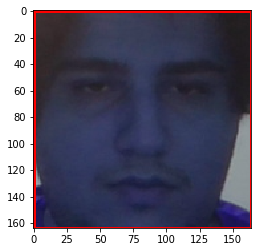

In [4]:
# get samples from webcam using cv2
path = 'G:\FaceMaskDetection\haarcascade_frontalface_default.xml'
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN


# background color ==> white
rectangle_bgr = (255, 255, 255)

# black image
img = np.zeros((500, 500))

# set some text
text = 'Some text in a box!'

(text_width, text_height) = cv2.getTextSize(text, font, fontScale=font_scale, thickness=1)[0]

# set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25

box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y + text_height - 2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale=font_scale, color=(0, 0, 0), thickness=1)
              
cap = cv2.VideoCapture(1)
# check if the webcam is ok
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    

# start
while True:
    
    ret, frame = cap.read()
   
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    
    for x, y, w, h in faces:
        roi_gray = gray[y: y + h, x: x + w]
        roi_color = frame[y: y + h, x: x + w]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
       
        if len(facess) == 0:
            print("Face Not Detected")
        else:
            for (ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex: ex+ew]
    plt.imshow(roi_color)
    
   
    final_image = cv2.resize(face_roi, (img_size, img_size))
    final_image = np.expand_dims(final_image, axis=0)
    final_image = final_image / 255.0
    font = cv2.FONT_HERSHEY_SIMPLEX
    print(final_image.shape)
    #plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
    predictions = new_model.predict(final_image)
    print('predictions is: ', predictions)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    # if prediction detects No mask or Mask
    if predictions >= 0.5:
        status = 'No Mask'
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255))
        
    else:
        status = 'Face Mask'
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 255, 0), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0))
    
    
    cv2.imshow("Face Mask Detection", frame)
    
    
    if cv2.waitKey(2)& 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
        

In [8]:
cap.release()
